In [22]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

# Loading in and dividing data
# reads in data
images = np.load("images.npy")
pv_out = np.load("pv_outputs.npy")

# randomly divides into a training set and a validation set
num_imgs = images.shape[0]
indices = np.arange(num_imgs)
np.random.shuffle(indices)
X_train, X_val = images[indices[:int(0.8 * num_imgs)]], images[indices[int(0.8 * num_imgs):]]
y_train, y_val = pv_out[indices[:int(0.8 * num_imgs)]], pv_out[indices[int(0.8 * num_imgs):]]

In [27]:
# The model
def cnn_model_depth5(X, y, is_training):
    # CBP sandwich 1
    conv1 = tf.layers.conv2d(
        inputs=X,
        filters=32,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    bn1 = tf.layers.batch_normalization(inputs=conv1, axis=1)
    conv2 = tf.layers.conv2d(
        inputs=bn1,
        filters=32,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    bn2 = tf.layers.batch_normalization(inputs=conv2, axis=1)
    conv3 = tf.layers.conv2d(
        inputs=bn2,
        filters=32,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    bn3 = tf.layers.batch_normalization(inputs=conv3, axis=1)
    pool1 = tf.layers.max_pooling2d(inputs=bn2, pool_size=[2, 2], strides=2)

    # CBP sandwich 2
    conv3 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    bn3 = tf.layers.batch_normalization(inputs=conv3, axis=1)
    conv4 = tf.layers.conv2d(
        inputs=bn3,
        filters=64,
        kernel_size=[3, 3],
        padding="same",
        activation=tf.nn.relu)
    bn4 = tf.layers.batch_normalization(inputs=conv4, axis=1)

    
    pool2_flat = tf.reshape(bn4, [-1, 30 * 30 * 64])
    
    # Fully connected nets
    dense1 = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
    bn_dense1 = tf.layers.batch_normalization(inputs=dense1)
    dropout1 = tf.layers.dropout(
        inputs=bn_dense1, rate=0.4, training=is_training)
    dense2 = tf.layers.dense(inputs=dropout1, units=1024, activation=tf.nn.relu)
    bn_dense2 = tf.layers.batch_normalization(inputs=dense2)
    dropout2 = tf.layers.dropout(
        inputs=bn_dense2, rate=0.4, training=is_training)
    dense3 = tf.layers.dense(inputs=dropout2, units=1024, activation=tf.nn.relu)
    bn_dense3 = tf.layers.batch_normalization(inputs=dense3)
    dropout3 = tf.layers.dropout(
        inputs=bn_dense3, rate=0.4, training=is_training)
    
    regression = tf.layers.dense(inputs=dropout3, units=1)
    regression = tf.reshape(regression, [-1])
    return regression

In [28]:
# Run model 
def run_model(session, pred_y_var, loss_var,
              x_var,y_var,is_training, Xd, yd,
              epoch_idx=0, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    rel_err_var = tf.divide(tf.abs(tf.subtract(y_var, pred_y_var)), y_var)
    accuracy = tf.reduce_mean(rel_err_var)

    # shuffle indices
    train_indices = np.arange(Xd.shape[0])
    np.random.shuffle(train_indices)
    training_now = training is not None

    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [loss_var, rel_err_var, accuracy]
    if training_now:
        variables[-1] = training

    # counter
    iter_cnt = 0

    # keep track of losses and accuracy
    errors = 0
    losses = []

    # make sure we iterate over the dataset once
    for i in range(int(Xd.shape[0] / batch_size)+1):
        # generate indices for the batch
        start_idx = (i * batch_size) % Xd.shape[0]
        idx = train_indices[start_idx:start_idx + batch_size]

        # create a feed dictionary for this batch
        feed_dict = {x_var: Xd[idx, :],
                     y_var: yd[idx],
                     is_training: training_now}
        # get batch size
        actual_batch_size = yd[i:i + batch_size].shape[0]

        # have tensorflow compute loss and correct predictions
        # and (if given) perform a training step
        loss, rel_err, _ = session.run(variables, feed_dict=feed_dict)

        # aggregate performance stats
        losses.append(loss * actual_batch_size)
        errors += np.sum(rel_err)

        # print every now and then
        if training_now and (iter_cnt % print_every) == 0:
            print("Iteration {0}: with minibatch training loss = {1:.3g} and relative error of {2:.2g}"
                  .format(iter_cnt, loss, np.sum(rel_err) / actual_batch_size))
        iter_cnt += 1
    total_error = errors / Xd.shape[0]
    total_loss = np.sum(losses) / Xd.shape[0]

    print("Epoch {2}, Overall loss = {0:.3g} and relative error of {1:.3g}"
          .format(total_loss, total_error, epoch_idx+1 ))

    if plot_losses:
        plt.plot(losses)
        plt.grid(True)
        plt.title('Epoch {} Loss'.format(epoch_idx + 1))
        plt.xlabel('minibatch number')
        plt.ylabel('minibatch loss')
        plt.show()

    return total_loss, total_error

In [29]:
# Build computational graph
tf.reset_default_graph()  # Reset computational graph

x_var = tf.placeholder(tf.float32, [None, 60, 60, 3]) # x variable
y_var = tf.placeholder(tf.float32, [None]) # y variable
is_training = tf.placeholder(tf.bool) # flag
pred_y_var = cnn_model_depth5(x_var, y_var, is_training) # model in use
mean_loss = tf.losses.mean_squared_error(y_var, pred_y_var) # loss in use

# Define optimizer and optimize session parameter
# define optimizer
optimizer = tf.train.AdamOptimizer(1e-3)
# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
pass

In [30]:
# Train the model
# initialize all variable
num_epochs = 20
sess = tf.Session()
sess.run(tf.global_variables_initializer())
# initialize loss and rel_err history list
train_loss_hist = []
train_error_hist = []
val_loss_hist = []
val_error_hist = []

for epoch_idx in range(num_epochs):
    print('Training')
    train_loss, train_error = run_model(sess, pred_y_var, mean_loss,
                                        x_var,y_var,is_training,
                                        X_train, y_train, epoch_idx, 100, 20, train_step,False)
    print('Validation')
    val_loss, val_error = run_model(sess, pred_y_var, mean_loss,
                                    x_var, y_var, is_training, X_val, y_val)
    
    train_loss_hist.append(train_loss)
    train_error_hist.append(train_error)
    val_loss_hist.append(val_loss)
    val_error_hist.append(val_error)

# Saving the model
model_name = "cnn_depth5"
saver = tf.train.Saver()
save_path = saver.save(sess, model_name + ".ckpt")
print("Model saved in file: %s" % save_path)

# Saving training history
train_loss = np.array(train_loss_hist)
np.save(model_name+"_train_loss", train_loss)
train_error = np.array(train_error_hist)
np.save(model_name+"_train_error", train_error)
val_loss = np.array(val_loss_hist)
np.save(model_name+"_val_loss", val_loss)
val_error = np.array(val_error_hist)
np.save(model_name+"_val_error", val_error)

Training
Iteration 0: with minibatch training loss = 4.58e+06 and relative error of 1
Iteration 20: with minibatch training loss = 1.63e+06 and relative error of 13
Iteration 40: with minibatch training loss = 4.58e+05 and relative error of 3
Iteration 60: with minibatch training loss = 6.23e+05 and relative error of 1.4
Iteration 80: with minibatch training loss = 6.2e+05 and relative error of 1.6
Iteration 100: with minibatch training loss = 6.12e+05 and relative error of 0.77
Epoch 1, Overall loss = 9.08e+05 and relative error of 3.45
Validation
Epoch 1, Overall loss = 4e+05 and relative error of 2.27
Training
Iteration 0: with minibatch training loss = 5.82e+05 and relative error of 3.8
Iteration 20: with minibatch training loss = 3.97e+05 and relative error of 1.1
Iteration 40: with minibatch training loss = 3.9e+05 and relative error of 1.2
Iteration 60: with minibatch training loss = 3.62e+05 and relative error of 1.1
Iteration 80: with minibatch training loss = 1.66e+05 and rel

In [31]:
# loading the model
saver = tf.train.Saver()
sess = tf.Session()
save_path = "./cnn_depth5.ckpt"
saver.restore(sess, save_path)
print("Model restored.")


Model restored.


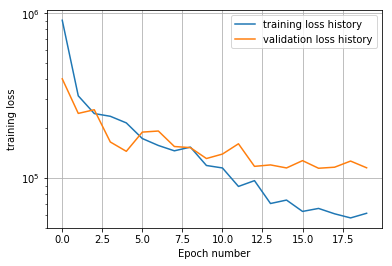

In [32]:
# Plotting final results
# plot training loss history
plt.plot(train_loss_hist,label= 'training loss history')
plt.plot(val_loss_hist,label= 'validation loss history')
plt.yscale('log')
plt.grid(True)
plt.xlabel('Epoch number')
plt.ylabel('training loss')
plt.legend()
plt.savefig('train_val_loss_history.png', bbox_inches='tight')
plt.show()

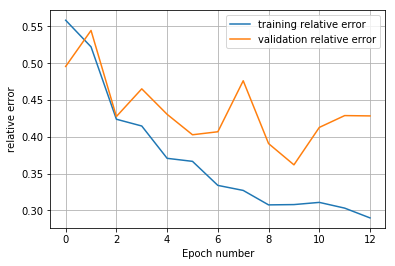

In [33]:
# plot relative error history
plt.plot(train_error_hist[7:], label='training relative error')
plt.plot(val_error_hist[7:], label='validation relative error')
plt.grid(True)
plt.xlabel('Epoch number')
plt.ylabel('relative error')
plt.legend()
plt.savefig('relative_error.png', bbox_inches='tight')
plt.show()

In [34]:
idx1 = np.arange(0,491) # a sunny day at 12-20-16
idx2 = np.arange(2730,3145) # a cloudy day at 1-1-17
idx3 = np.arange(5420,5843) # a rainy  day at 1-8-17

idx = np.concatenate((idx1,idx2,idx3))

print(idx.shape)

(1329,)


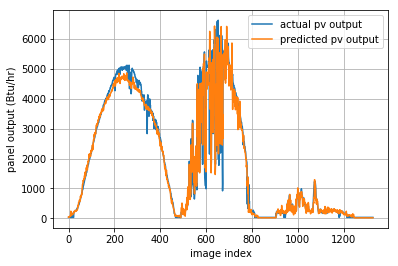

RMSE:  303.08


In [35]:
idx= idx
feed_dict = {x_var: images[idx],y_var: pv_out[idx],is_training: False}

mse,pred_y_value = sess.run([mean_loss,pred_y_var], feed_dict=feed_dict)

plt.plot(pv_out[idx], label='actual pv output')
plt.plot(pred_y_value, label='predicted pv output')
plt.grid(True)
plt.xlabel('image index')
plt.ylabel('panel output (Btu/hr)')
plt.legend()
plt.savefig('predicted_and_actual_output.png', bbox_inches='tight')
plt.show()

print('RMSE: ', np.sqrt(mse))